### AIM: Extract Time-Frequency object from EEG data and store in Numpy array for each participant's first session

Numpy array shape: [EC/EO, n_epochs, n_channels, n_freqs, n_times]

In [2]:
import os
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import mne
from mne.time_frequency import tfr_morlet, tfr_multitaper

%matplotlib inline

In [3]:
# prevent extensive logging
mne.set_log_level('WARNING')

In [4]:
# set folder containing participants data as working directory
participants_dir = "D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN_participants_V2_data"
os.chdir(participants_dir)
os.getcwd()

'D:\\Documents\\RU\\Master_Neurobiology\\Internship_jaar_2\\Project\\TD-BRAIN\\TDBRAIN_participants_V2_data'

In [5]:
## Set montage based on channel names and locations provided in Van Dijk et al., (2022) (Copied from Anne van Duijvenbode)

ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',\
           'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', \
           'eog', 'eog', 'eog', 'eog', 'ecg', 'eog', 'emg']

ch_names = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC3', 'FCz', 'FC4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP3', \
            'CPz', 'CP4', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2', 'VPVA', 'VNVB', 'HPHL', 'HNHR', 'Erbs', \
            'OrbOcc', 'Mass']

dict_eeg_channels =  {ch_names[i]: ch_types[i] for i in range(len(ch_types))}

dict_ch_pos = {'Fp1' : [-26.81, 84.06, -10.56],
               'Fp2' : [29.41, 83.74, -10.04],
               'F7'  : [-66.99, 41.69, -15.96],
               'F3'  : [-48.05, 51.87, 39.87],
               'Fz'  : [0.90, 57.01, 66.36],
               'F4'  : [50.38, 51.84, 41.33],
               'F8'  : [68.71, 41.16, -15.31],
               'FC3' : [-58.83, 21.02, 54.82],
               'FCz' : [0.57, 24.63, 87.63],
               'FC4' : [60.29, 21.16, 55.58], 
               'T7'  : [-83.36, -16.52, -12.65], 
               'C3'  : [-65.57, -13.25, 64.98],
               'Cz'  : [0.23, -11.28, 99.81],
               'C4'  : [66.50, -12.80, 65.11],
               'T8'  : [84.44, -16.65, -11.79], 
               'CP3' : [-65.51, -48.48, 68.57],
               'CPz' : [-0.42, -48.77, 98.37], 
               'CP4' : [65.03, -48.35, 68.57], 
               'P7': [-71.46, -75.17, -3.70], 
               'P3'  : [-55.07, -80.11, 59.44], 
               'Pz'  : [-0.87, -82.23, 82.43],
               'P4'  : [53.51, -80.13, 59.40], 
               'P8' : [71.10, -75.17, -3.69], 
               'O1'  : [-28.98, -114.52, 9.67],  
               'Oz'  : [-1.41, -117.79, 15.84],
               'O2'  : [26.89, -114.68, 9.45]
              }

dict_ch_pos_m = {'Fp1' : [-0.2681, 0.8406, -0.1056],
               'Fp2' : [0.2941, 0.8374, -0.1004],
               'F7'  : [-0.6699, 0.4169, -0.1596],
               'F3'  : [-0.4805, 0.5187, 0.3987],
               'Fz'  : [0.0090, 0.5701, 0.6636],
               'F4'  : [0.5038, 0.5184, 0.4133],
               'F8'  : [0.6871, 0.4116, -0.1531],
               'FC3' : [-0.5883, 0.2102, 0.5482],
               'FCz' : [0.0057, 0.2463, 0.8763],
               'FC4' : [0.6029, 0.2116, 0.5558], 
               'T7'  : [-0.8336, -0.1652, -0.1265], 
               'C3'  : [-0.6557, -0.1325, 0.6498],
               'Cz'  : [0.0023, -0.1128, 0.9981],
               'C4'  : [0.6650, -0.1280, 0.6511],
               'T8'  : [0.8444, -0.1665, -0.1179], 
               'CP3' : [-0.6551, -0.4848, 0.6857],
               'CPz' : [-0.042, -0.4877, 0.9837], 
               'CP4' : [0.6503, -0.4835, 0.6857], 
               'P7'  : [-0.7146, -0.7517, -0.0370], 
               'P3'  : [-0.5507, -0.8011, 0.5944], 
               'Pz'  : [-0.0087, -0.8223, 0.8243],
               'P4'  : [0.5351, -0.8013, 0.5940], 
               'P8'  : [0.7110, -0.7517, -0.0369], 
               'O1'  : [-0.2898, -1.1452, 0.0967],  
               'Oz'  : [-0.0141, -1.1779, 0.1584],
               'O2'  : [0.2689, -1.1468, 0.0945]
              }

dict_ch_pos_array = {'Fp1' : np.array([-0.02681, 0.08406, -0.01056]),
               'Fp2' : np.array([0.02941, 0.08374, -0.01004]),
               'F7'  : np.array([-0.06699, 0.04169, -0.01596]),
               'F3'  : np.array([-0.04805, 0.05187, 0.03987]),
               'Fz'  : np.array([0.00090, 0.05701, 0.06636]),
               'F4'  : np.array([0.05038, 0.05184, 0.04133]),
               'F8'  : np.array([0.06871, 0.04116, -0.01531]),
               'FC3' : np.array([-0.05883, 0.02102, 0.05482]),
               'FCz' : np.array([0.00057, 0.02463, 0.08763]),
               'FC4' : np.array([0.06029, 0.02116, 0.05558]), 
               'T7'  : np.array([-0.08336, -0.01652, -0.01265]), 
               'C3'  : np.array([-0.06557, -0.01325, 0.06498]),
               'Cz'  : np.array([0.000023, -0.01128, 0.09981]),
               'C4'  : np.array([0.06650, -0.01280, 0.06511]),
               'T8'  : np.array([0.08444, -0.01665, -0.01179]), 
               'CP3' : np.array([-0.06551, -0.04848, 0.06857]),
               'CPz' : np.array([-0.0042, -0.04877, 0.09837]), 
               'CP4' : np.array([0.06503, -0.04835, 0.06857]), 
               'P7'  : np.array([-0.07146, -0.07517, -0.00370]), 
               'P3'  : np.array([-0.05507, -0.08011, 0.05944]), 
               'Pz'  : np.array([-0.00087, -0.08223, 0.08243]),
               'P4'  : np.array([0.05351, -0.08013, 0.05940]), 
               'P8'  : np.array([0.07110, -0.07517, -0.00369]), 
               'O1'  : np.array([-0.02898, -0.11452, 0.00967]),  
               'Oz'  : np.array([-0.00141, -0.11779, 0.01584]),
               'O2'  : np.array([0.02689, -0.11468, 0.00945])
              }


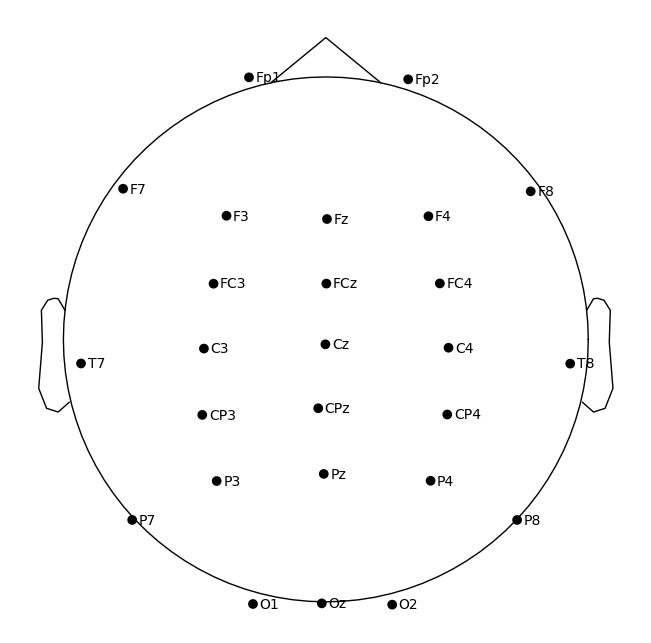

In [6]:
## Set montage and plot electrodes (Copied from Anne van Duijvenbode)

montage = mne.channels.make_dig_montage(ch_pos = dict_ch_pos_array, coord_frame = 'head')
mne.viz.plot_montage(montage = montage, scale_factor=10, show_names=True, show=True, sphere='eeglab')

montage.save('montage_eeg.fif', overwrite = True)

In [7]:
# Create info object for MNE
info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=500)
info.set_montage(montage=montage, on_missing= 'raise')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC3, FCz, FC4, T7, C3, Cz, C4, T8, ...
 chs: 26 EEG, 5 EOG, 1 ECG, 1 EMG
 custom_ref_applied: False
 dig: 29 items (3 Cardinal, 26 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 500.0 Hz
>


# Time-frequency analysis

First for singular participant to determine workflow:

In [8]:
# load data and create epochs
eeg_data_path = 'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TDBRAIN-dataset-derivatives\derivatives\sub-88078657\ses-1\eeg\sub-88078657_ses-1_task-restEC_eeg.csv'
eeg_data = pd.read_csv(eeg_data_path, sep=',')
eeg_data = eeg_data.transpose().to_numpy() # transpose data because MNE expects one channel per row instead of per column

raw = mne.io.RawArray(eeg_data, info) # load data as MNE object, with the previously created 'info'
raw.notch_filter(50)
raw.filter(0.5, 100)
        
epochs = mne.make_fixed_length_epochs(raw, duration = 10, overlap = 0) # overlap 0?
print(epochs)

<Epochs |  12 events (good & bad), 0 – 9.998 s, baseline off, ~40 kB, data not loaded,
 '1': 12>


### Morlet wave convolution

In [10]:
# define frequencies of interest (log-spaced) (just random for now)
freqs = np.arange(1, 91, 1, dtype=int) 
print(f'{freqs = }')
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR = tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

power, itc= tfr_morlet(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    average=True,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

freqs = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])


In [11]:
print(epochsTFR) # TFR for each epoch seperate
print(power) # TFR averaged over all epochs

<EpochsTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>
<AverageTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], nave : 12, channels : 26, ~89.3 MB>


### Multitaper method

In [12]:
# define frequencies of interest (log-spaced) (just random for now)
freqs = np.arange(1, 91, 1, dtype=int) 
print(f'{freqs = }')
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR_mt = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=False,
    average=False,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

power_mt, itc_mt= tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=True,
    average=True,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

freqs = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])


In [98]:
print(epochsTFR_mt) # TFR for each epoch seperate
print(power_mt) # TFR averaged over all epochs

<EpochsTFR | time : [0.000000, 9.998000], freq : [0.500000, 35.000000], epochs : 12, channels : 26, ~95.2 MB>
<AverageTFR | time : [0.000000, 9.998000], freq : [0.500000, 35.000000], nave : 12, channels : 26, ~8.0 MB>


### Comparing Morlet vs Multitaper

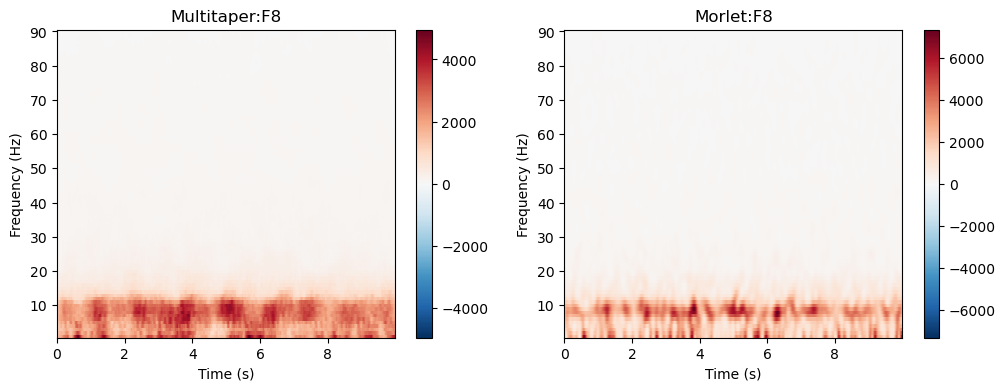

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

power_mt.plot([6], axes=ax1, show=False)
power.plot([6], axes=ax2, show=False)
ax1.set_title(f'Multitaper:{ch_names[6]}')
ax2.set_title(f'Morlet:{ch_names[6]}')
plt.show()

Text(0.5, 0.98, 'Morlet')

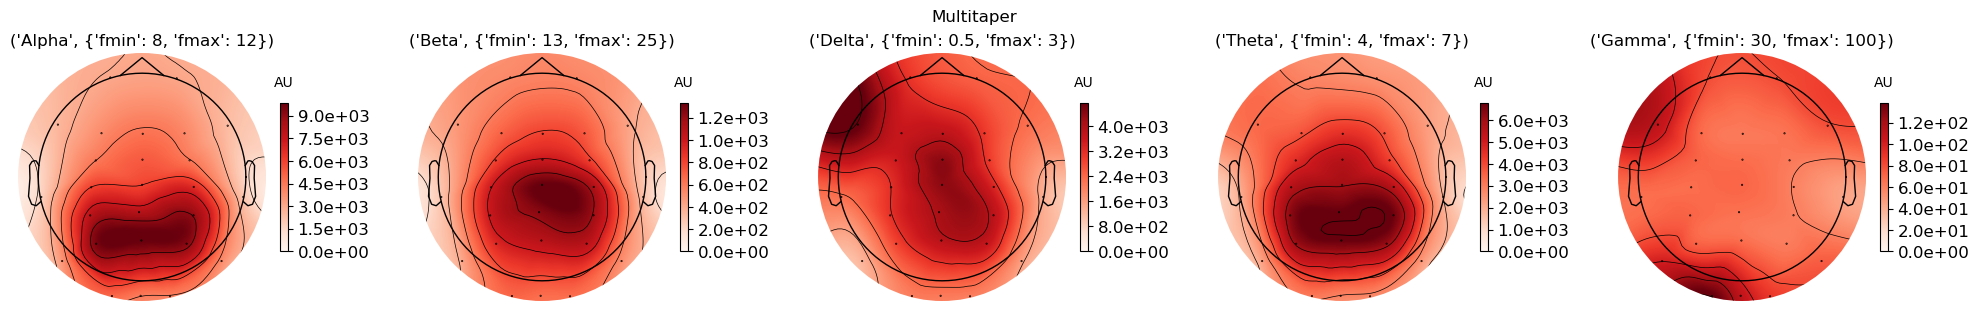

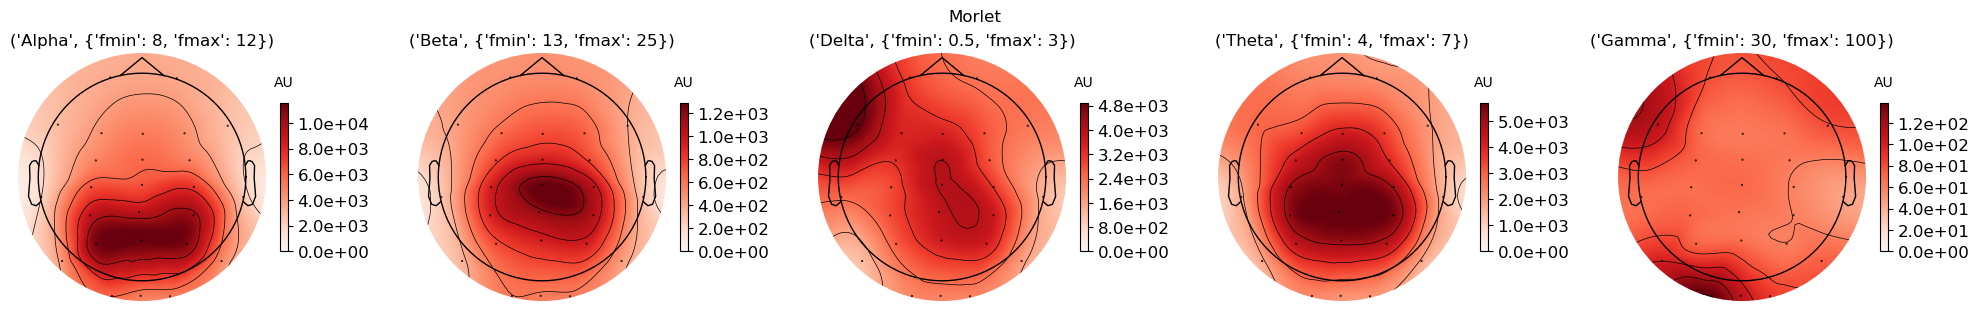

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(20, 3), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=1, tmax=2, show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25), Delta=dict(fmin=0.5, fmax=3), Theta=dict(fmin=4, fmax=7), Gamma=dict(fmin=30, fmax=100))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power_mt.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title((title, fmin_fmax))
fig.suptitle('Multitaper')

fig, axes = plt.subplots(1, 5, figsize=(20, 3), layout="constrained")
topomap_kw = dict(
    ch_type="eeg", tmin=1, tmax=2, show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25), Delta=dict(fmin=0.5, fmax=3), Theta=dict(fmin=4, fmax=7), Gamma=dict(fmin=30, fmax=100))
for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
    power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
    ax.set_title((title, fmin_fmax))
fig.suptitle('Morlet')


### Now, use the workflow for a single participant to create loop for all participants 

In [16]:
# define frequencies of interest (log-spaced) (just random for now)
freqs = np.arange(1, 91, 1, dtype=int) 
print(f'{freqs = }')
n_cycles = freqs / 2.0 # different number of cycles per frequency

epochsTFR_mt = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=False,
    average=False,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

power_mt, itc_mt = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=n_cycles,
    time_bandwidth=4, # just random for now
    use_fft=True,
    return_itc=True,
    average=True,
    decim=1, # decim reduces sampling rate of the tf decomposition by the defined factor
    n_jobs=-1)

freqs = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90])


In [17]:
print(epochsTFR_mt) # TFR for each epoch seperate
print(power_mt) # TFR averaged over all epochs

<EpochsTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], epochs : 12, channels : 26, ~1.05 GB>
<AverageTFR | time : [0.000000, 9.998000], freq : [1.000000, 90.000000], nave : 12, channels : 26, ~89.3 MB>


In [18]:
print(power_mt.data.shape) # shape (n_channels, n_freqs, n_times)
print(epochsTFR_mt.data.shape) # shape (n_epochs, n_channels, n_freqs, n_times)

(26, 90, 5000)
(12, 26, 90, 5000)


In [31]:
# try storing the MNE TFR object in numpy arrays
a = np.array(power_mt) # storing as object
b = np.array(power_mt)
c = np.append(a, b)
print(c.shape)
c[0].info # data is correctly stored and retrieved from object in numpy array

(2,)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,29 points
Good channels,26 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [26]:
# try storing the MNE TFR object in multidimensional numpy array
a = np.array(epochsTFR_mt)
b = np.expand_dims(a, axis=0)
b.shape


(1, 12, 26, 90, 5000)

In [37]:
a = np.array(power_mt)
b = np.expand_dims(a, axis=0)
print(a.shape)
print(b.shape)

()
(1,)


In [62]:
# try appending two multidimensional numpy arrays containing EpochsTFR data and check size
a = np.array([epochsTFR_mt])
b = np.array([epochsTFR_mt])
c = np.append(a, b, axis=0)
print(c.shape)
print(c.nbytes)

extracted_epochsTFR = c[0]
print(extracted_epochsTFR.nbytes)
print(extracted_epochsTFR.shape)

np.save('test_array.npy', c) # 2+ GB!!
print('.npy file is 2+ GB. If storing for all 1350 participants, I would need 2.7+ TB of storage')

(2, 12, 26, 90, 5000)
2246400000
1123200000
(12, 26, 90, 5000)
.npy file is 2+ GB. If storing for all 1350 participants, I would need 2.7+ TB of storage


In [63]:
# try appending two multidimensional numpy arrays containing AverageTFR data and check size
a = np.array([power_mt])
b = np.array([power_mt])
c = np.append(a, b, axis=0)
print(c.shape)
print(c.nbytes)

extracted_power = c[0]
print(extracted_power.data.nbytes)
print(extracted_power.data.shape)

np.save('test_array.npy', c) # 90 MB
print('.npy file is 90 MB. More managable, but data is averaged over epochs, and still 121.5 GB of storage needed for all participants')

(2,)
16
93600000
(26, 90, 5000)
.npy file is 90 MB. More managable, but data is averaged over epochs, and still 121.5 GB of storage needed for all participants
